In [1]:
# Parameters
seed = 32
run = 1


# WORKSPACE SETUP

In [2]:
# HYPERPARAMETER SETTINGS
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
use_physics_in_loss=True 
monitor_physics=True
# Reproducibility settings
seed = seed
split_seed = 42
# Hyperparameters
hidden_dim=64
graph_layers=2
fc_layers=3
lr = 0.0015725630394219055
weight_decay = 3.974062330707054e-06
num_epochs = 200
batch_size = 32
runtime = timestamp
runtyp = 'RASHYB_multirun_pinn'
# Thermo loss strength
s1 = 10
s2 = 1000
s3 = 1

print('seed             :', seed)
print('split seed       :', split_seed)
print('hidden_dim       :', hidden_dim)
print('lr               :', lr)
print('decay            :', weight_decay)
print('batch_size       :', batch_size)
print('max_epochs       :', num_epochs)
print('gradP strength   :', s1)
print('gradT strength   :', s2)
print('gradC strength   :', s3)

seed             : 32
split seed       : 42
hidden_dim       : 64
lr               : 0.0015725630394219055
decay            : 3.974062330707054e-06
batch_size       : 32
max_epochs       : 200
gradP strength   : 10
gradT strength   : 1000
gradC strength   : 1


In [3]:
# IMPORTING LIBRARIES
import copy
import csv
import os
import random
import time
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # or ':16:8'

import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import Descriptors
from rdkit.Chem.rdchem import GetPeriodicTable

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch_geometric.nn import MessagePassing, GCNConv, global_mean_pool, GATConv
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader

import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# FUNCTIONS
from data_processing import load_dataset, process_dataset
from path_helpers import get_path
from stats_compute import compute_statistics, scale_graphs
import ModelArchitecture
from EnhancedDataSplit import DataSplitter

from collections import defaultdict
from typing import Tuple, List

# DIRECTORY SETUP
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

In [4]:
# CUDA Deterministic (ON/OFF SETTING)
# For PyTorch
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

selected_device = 'cuda' # either 'cuda' or 'cpu
device = torch.device(selected_device)
print('device           :', device)

device           : cuda


In [5]:
# FUNCTION -> TRAINING LOOP
def train_one_epoch(model, train_loader, criterion, optimizer, device, 
                    pco2_std, temp_std, conc_std,
                    pco2_mean, temp_mean, conc_mean,
                    s1, s2, s3, 
                    use_physics_in_loss=True, monitor_physics=True):
    model.train()
    total_loss = 0
    total_main_loss = 0
    total_thermo1_loss = 0
    total_thermo2_loss = 0
    total_thermo3_loss = 0
    
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        loss_main = criterion(output, data.aco2.view(-1, 1))
        
        # Calculate physics losses
        if use_physics_in_loss or monitor_physics:
            loss_thermo1 = ModelArchitecture.grad_pres(model, data, pco2_std, pco2_mean, s1) if s1 != 0 else 0.0
            loss_thermo2 = ModelArchitecture.grad_temp(model, data, temp_std, temp_mean, s2) if s2 != 0 else 0.0
            loss_thermo3 = ModelArchitecture.grad_conc(model, data, conc_std, conc_mean, s3) if s3 != 0 else 0.0
        else:
            loss_thermo1 = loss_thermo2 = loss_thermo3 = 0.0
        
        # Only include physics losses in backprop if use_physics_in_loss=True
        if use_physics_in_loss:
            loss = loss_main + loss_thermo1 + loss_thermo2 + loss_thermo3
        else:
            loss = loss_main
            
        loss.backward()
        optimizer.step()
        
        # Track total loss consistently with what was actually backpropagated
        if use_physics_in_loss:
            total_loss += loss.item()  # This includes physics losses
        else:
            total_loss += loss_main.item()
        total_main_loss += loss_main.item()
        total_thermo1_loss += loss_thermo1.item() if isinstance(loss_thermo1, torch.Tensor) else loss_thermo1
        total_thermo2_loss += loss_thermo2.item() if isinstance(loss_thermo2, torch.Tensor) else loss_thermo2
        total_thermo3_loss += loss_thermo3.item() if isinstance(loss_thermo3, torch.Tensor) else loss_thermo3
    
    # Calculate averages
    avg_train_loss = total_loss / len(train_loader)
    avg_main_loss = total_main_loss / len(train_loader)
    avg_thermo1_loss = total_thermo1_loss / len(train_loader)
    avg_thermo2_loss = total_thermo2_loss / len(train_loader)
    avg_thermo3_loss = total_thermo3_loss / len(train_loader)
    
    return avg_train_loss, avg_main_loss, avg_thermo1_loss, avg_thermo2_loss, avg_thermo3_loss


# Validation Step
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.aco2.view(-1, 1))
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

# Test Evaluation (Metrics)
def evaluate_test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_outputs = []
    test_targets = []
    
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.aco2.view(-1, 1))
            test_loss += loss.item()
            test_outputs.append(output.cpu().numpy())
            test_targets.append(data.aco2.view(-1, 1).cpu().numpy())
    
    test_outputs = np.concatenate(test_outputs, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)
    test_r2 = r2_score(test_targets, test_outputs)
    avg_test_loss = test_loss / len(test_loader)
    
    return avg_test_loss, test_r2

# Loss Plotting
def plot_losses(train_losses, val_losses, test_losses, test_r2_scores, 
                main_losses, thermo1_losses, thermo2_losses, thermo3_losses, 
                stopped_epoch=None):
    # Original combined loss plot
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Total Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
    if stopped_epoch:
        plt.axvline(x=stopped_epoch, color='red', linestyle='--', alpha=0.7, label=f'Early Stop (Epoch {stopped_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training, Validation and Test Loss Curves')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(test_r2_scores) + 1), test_r2_scores, color='green')
    if stopped_epoch:
        plt.axvline(x=stopped_epoch, color='red', linestyle='--', alpha=0.7, label=f'Early Stop (Epoch {stopped_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('R² Score')
    plt.title('Test R² Score per Epoch')
    plt.legend() if stopped_epoch else None
    plt.grid(True)

    # Individual physics loss components
    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(main_losses) + 1), main_losses, label='Main Loss', color='blue')
    plt.plot(range(1, len(thermo1_losses) + 1), thermo1_losses, label='Partial pressure gradient (s1)', color='red')
    plt.plot(range(1, len(thermo2_losses) + 1), thermo2_losses, label='Temperature gradient (s2)', color='orange')
    plt.plot(range(1, len(thermo3_losses) + 1), thermo3_losses, label='Concentration gradient (s3)', color='purple')
    if stopped_epoch:
        plt.axvline(x=stopped_epoch, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Individual Loss Components')
    plt.legend()
    plt.grid(True)

    # Physics losses only (zoomed view)
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(thermo1_losses) + 1), thermo1_losses, label='Partial pressure gradient (s1)', color='red')
    plt.plot(range(1, len(thermo2_losses) + 1), thermo2_losses, label='Temperature gradient (s2)', color='orange')
    plt.plot(range(1, len(thermo3_losses) + 1), thermo3_losses, label='Concentration gradient (s3)', color='purple')
    if stopped_epoch:
        plt.axvline(x=stopped_epoch, color='red', linestyle='--', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Physics Loss Components (Zoomed)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main Training Loop with Early Stopping and Best Weight Restoration
def train_model(model, train_loader, val_loader, 
                test_loader, criterion, optimizer, 
                pco2_std, temp_std, conc_std,
                pco2_mean, temp_mean, conc_mean,
                s1, s2, s3,
                device, num_epochs, 
                seed, parent_directory,
                use_physics_in_loss=True, monitor_physics=True,
                patience=10, min_delta=1e-5):
    """
    Args:
        use_physics_in_loss (bool): Whether to include physics losses in backpropagation
        monitor_physics (bool): Whether to compute and track physics losses for monitoring
        patience (int): Number of epochs to wait for improvement before stopping
        min_delta (float): Minimum change in validation loss to qualify as improvement
    """
    # Initialize loss tracking lists
    train_losses, val_losses, test_losses, test_r2_scores = [], [], [], []
    main_losses, thermo1_losses, thermo2_losses, thermo3_losses = [], [], [], []

    # Early stopping variables
    best_val_loss = float('inf')
    best_model_weights = None  # Store best model weights in memory
    best_epoch = 0
    epochs_no_improve = 0
    stopped_epoch = None

    # Print training mode
    if use_physics_in_loss and monitor_physics:
        print("Training with physics losses in backpropagation + monitoring")
    elif monitor_physics and not use_physics_in_loss:
        print("Training with Main Loss only, but monitoring physics losses")
    elif use_physics_in_loss and not monitor_physics:
        print("Training with physics losses in backpropagation (no monitoring)")
    else:
        print("Training with Main Loss only (no physics)")
    
    print(f"Early stopping enabled: patience={patience}, min_delta={min_delta}")

    for epoch in range(num_epochs):
        # Get individual loss components from training
        avg_train_loss, avg_main_loss, avg_thermo1_loss, avg_thermo2_loss, avg_thermo3_loss = train_one_epoch(
            model, train_loader, criterion, optimizer, device, 
            pco2_std, temp_std, conc_std, 
            pco2_mean, temp_mean, conc_mean,
            s1, s2, s3, use_physics_in_loss, monitor_physics)

        avg_val_loss = validate(model, val_loader, criterion, device)
        avg_test_loss, test_r2 = evaluate_test(model, test_loader, criterion, device)

        # Store all losses
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        test_losses.append(avg_test_loss)
        test_r2_scores.append(test_r2)
        main_losses.append(avg_main_loss)
        thermo1_losses.append(avg_thermo1_loss)
        thermo2_losses.append(avg_thermo2_loss)
        thermo3_losses.append(avg_thermo3_loss)

        # Early stopping check and best model tracking
        if avg_val_loss < (best_val_loss - min_delta):
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            epochs_no_improve = 0
            # Store the best model weights in memory (deep copy)
            best_model_weights = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            epochs_no_improve += 1

        # Enhanced print statement with individual loss components
        if monitor_physics:
            physics_info = f'Main Loss: {round(avg_main_loss, 4)}, gradP: {round(avg_thermo1_loss, 4)}, gradT: {round(avg_thermo2_loss, 4)}, gradC: {round(avg_thermo3_loss, 4)}'
            physics_status = " [BACKPROP]" if use_physics_in_loss else " [MONITOR]"
        else:
            physics_info = f'Main Loss: {round(avg_main_loss, 4)}'
            physics_status = ""
            
        early_stop_info = f" (No improve: {epochs_no_improve}/{patience})" if epochs_no_improve > 0 else ""
        best_marker = " *BEST*" if epoch + 1 == best_epoch else ""
            
        print(f'Epoch {epoch+1}/{num_epochs}, Total Loss: {round(avg_train_loss, 4)}, '
              f'Val Loss: {round(avg_val_loss, 4)}, Test Loss: {round(avg_test_loss, 4)}, '
              f'Test R2: {round(test_r2, 4)} | {physics_info}{physics_status}{early_stop_info}{best_marker}')
        
        # Check if we should stop early
        if epochs_no_improve >= patience:
            stopped_epoch = epoch + 1
            print(f"\nEarly stopping triggered at epoch {stopped_epoch}")
            print(f"Best validation loss: {round(best_val_loss, 6)} at epoch {best_epoch}")
            break
    
    # Restore the best model weights
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nRestored model weights from epoch {best_epoch} (best validation loss: {round(best_val_loss, 6)})")
    else:
        print("\nWarning: No improvement found during training, keeping final weights")
    
    # Final summary
    if stopped_epoch is None:
        print(f"Training completed all {num_epochs} epochs")
    else:
        print(f"Training stopped early at epoch {stopped_epoch}/{num_epochs}")
    
    print(f"Model now contains weights from epoch {best_epoch}")
    print(f"Final test R² with best weights: {round(test_r2_scores[best_epoch-1], 6)}")
    
    # Plot all losses including individual components
    plot_losses(train_losses, val_losses, test_losses, test_r2_scores, 
                main_losses, thermo1_losses, thermo2_losses, thermo3_losses,
                stopped_epoch)
    
    # Return all tracked losses and stopping info, plus best epoch info
    return (train_losses, val_losses, test_losses, test_r2_scores, 
            main_losses, thermo1_losses, thermo2_losses, thermo3_losses,
            stopped_epoch, best_val_loss, best_epoch)

In [6]:
# LOAD & GRAPH GENERATION
df_components = load_dataset(get_path(file_name = 'components_set.csv', folder_name='datasets'))
smiles_dict = dict(zip(df_components['Abbreviation'], df_components['SMILES']))
df_systems = load_dataset(get_path(file_name = 'systems_set.csv', folder_name='datasets'))
smiles_list = df_components["SMILES"].dropna().tolist()
mol_name_dict = smiles_dict.copy()
# GRAPH
system_graphs = process_dataset(df_systems, smiles_dict)

In [7]:
# LOAD DATASET
splitter_1 = DataSplitter(system_graphs, random_state=split_seed)
RASset1, RASset2, RASset3 = splitter_1.rarity_aware_unseen_amine_split()
opt_data = RASset1 + RASset2

# HYBRID
splitter_2 = DataSplitter(opt_data, random_state=split_seed)
SRSset1, SRSset2, SRSset3 = splitter_2.stratified_random_split()
train_data = SRSset1
val_data = SRSset2 + SRSset3
test_data = RASset3
#Retrieve the statistics of train_data
stats = compute_statistics(train_data)
conc_mean = stats[0]
conc_std = stats[1]
temp_mean = stats[2]
temp_std = stats[3]
pco2_mean = stats[4]
pco2_std = stats[5]
#Apply the scaling to validation and test
original_train_data = copy.deepcopy(train_data)
original_val_data = copy.deepcopy(val_data)
original_test_data = copy.deepcopy(test_data)
combined_original_data = original_train_data + original_val_data + original_test_data
train_data = scale_graphs(train_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
val_data = scale_graphs(val_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
test_data = scale_graphs(test_data, conc_mean, conc_std, temp_mean, temp_std, pco2_mean, pco2_std)
#Load the data into DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


Processing Very Rare types:
  primary-secondary-tertiary: 1 train, 0 val, 0 test
  2-primary-secondary: 1 train, 0 val, 0 test
  2-primary-3-secondary: 1 train, 0 val, 0 test
  2-primary-2-secondary: 1 train, 0 val, 0 test

Processing Rare types:
  2-secondary: 1 train, 1 val, 0 test
  primary-secondary: 2 train, 1 val, 0 test
  2-tertiary: 1 train, 1 val, 0 test

Processing Medium types:
  secondary-tertiary: 1 train, 1 val, 1 test
  2-primary: 1 train, 1 val, 1 test

Processing Common types:
  primary: 11 train, 2 val, 2 test
  tertiary: 14 train, 2 val, 2 test
  secondary: 10 train, 1 val, 1 test
Rarity Classification:

Very Rare:
  2-primary-3-secondary: 10 samples, 1 amines [TEPA]
  2-primary-2-secondary: 22 samples, 1 amines [TETA]
  2-primary-secondary: 94 samples, 1 amines [DETA]
  primary-secondary-tertiary: 173 samples, 1 amines [AEPZ]

Rare:
  2-tertiary: 36 samples, 2 amines [TEMED, DMPZ]
  2-secondary: 78 samples, 2 amines [2MPZ, PZ]
  primary-secondary: 113 samples, 3 am

Training final model with optimized hyperparameters...
Training with physics losses in backpropagation + monitoring
Early stopping enabled: patience=10, min_delta=1e-06


Epoch 1/200, Total Loss: 0.0578, Val Loss: 0.0528, Test Loss: 0.0239, Test R2: 0.043 | Main Loss: 0.0578, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 2/200, Total Loss: 0.0386, Val Loss: 0.0258, Test Loss: 0.0165, Test R2: 0.3234 | Main Loss: 0.0386, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 3/200, Total Loss: 0.0205, Val Loss: 0.0238, Test Loss: 0.0165, Test R2: 0.4209 | Main Loss: 0.0205, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 4/200, Total Loss: 0.0214, Val Loss: 0.0185, Test Loss: 0.0242, Test R2: 0.3677 | Main Loss: 0.0214, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 5/200, Total Loss: 0.0185, Val Loss: 0.0161, Test Loss: 0.0185, Test R2: 0.5557 | Main Loss: 0.0185, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 6/200, Total Loss: 0.0141, Val Loss: 0.0131, Test Loss: 0.0103, Test R2: 0.7162 | Main Loss: 0.0141, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 7/200, Total Loss: 0.0136, Val Loss: 0.0127, Test Loss: 0.018, Test R2: 0.5889 | Main Loss: 0.0136, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 8/200, Total Loss: 0.0115, Val Loss: 0.0103, Test Loss: 0.0094, Test R2: 0.7236 | Main Loss: 0.0115, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 9/200, Total Loss: 0.0108, Val Loss: 0.0114, Test Loss: 0.012, Test R2: 0.6674 | Main Loss: 0.0108, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 10/200, Total Loss: 0.0102, Val Loss: 0.0096, Test Loss: 0.007, Test R2: 0.7667 | Main Loss: 0.0101, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 11/200, Total Loss: 0.0091, Val Loss: 0.0082, Test Loss: 0.0076, Test R2: 0.7508 | Main Loss: 0.0091, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 12/200, Total Loss: 0.0084, Val Loss: 0.0096, Test Loss: 0.0079, Test R2: 0.7615 | Main Loss: 0.0084, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 13/200, Total Loss: 0.0087, Val Loss: 0.011, Test Loss: 0.0063, Test R2: 0.7428 | Main Loss: 0.0087, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 14/200, Total Loss: 0.0089, Val Loss: 0.0097, Test Loss: 0.0064, Test R2: 0.7994 | Main Loss: 0.0089, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 15/200, Total Loss: 0.0093, Val Loss: 0.0079, Test Loss: 0.0069, Test R2: 0.7606 | Main Loss: 0.0092, gradP: 0.0, gradT: 0.0001, gradC: 0.0 [BACKPROP] *BEST*


Epoch 16/200, Total Loss: 0.0078, Val Loss: 0.0126, Test Loss: 0.0093, Test R2: 0.5929 | Main Loss: 0.0078, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 17/200, Total Loss: 0.008, Val Loss: 0.0085, Test Loss: 0.0065, Test R2: 0.7392 | Main Loss: 0.008, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 18/200, Total Loss: 0.0079, Val Loss: 0.008, Test Loss: 0.0048, Test R2: 0.8377 | Main Loss: 0.0079, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 19/200, Total Loss: 0.0066, Val Loss: 0.0065, Test Loss: 0.0037, Test R2: 0.8583 | Main Loss: 0.0066, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 20/200, Total Loss: 0.007, Val Loss: 0.0078, Test Loss: 0.0058, Test R2: 0.7789 | Main Loss: 0.007, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 21/200, Total Loss: 0.007, Val Loss: 0.0118, Test Loss: 0.0042, Test R2: 0.8374 | Main Loss: 0.0069, gradP: 0.0, gradT: 0.0001, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 22/200, Total Loss: 0.0077, Val Loss: 0.0074, Test Loss: 0.0063, Test R2: 0.749 | Main Loss: 0.0077, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 23/200, Total Loss: 0.0065, Val Loss: 0.006, Test Loss: 0.0037, Test R2: 0.8527 | Main Loss: 0.0064, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 24/200, Total Loss: 0.0069, Val Loss: 0.0075, Test Loss: 0.0058, Test R2: 0.7823 | Main Loss: 0.0068, gradP: 0.0, gradT: 0.0001, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 25/200, Total Loss: 0.0066, Val Loss: 0.0065, Test Loss: 0.0045, Test R2: 0.8149 | Main Loss: 0.0066, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 26/200, Total Loss: 0.0058, Val Loss: 0.0059, Test Loss: 0.0045, Test R2: 0.8112 | Main Loss: 0.0058, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 27/200, Total Loss: 0.0068, Val Loss: 0.0067, Test Loss: 0.0059, Test R2: 0.748 | Main Loss: 0.0067, gradP: 0.0, gradT: 0.0001, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 28/200, Total Loss: 0.006, Val Loss: 0.0063, Test Loss: 0.0048, Test R2: 0.8151 | Main Loss: 0.006, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 29/200, Total Loss: 0.0057, Val Loss: 0.007, Test Loss: 0.0051, Test R2: 0.7873 | Main Loss: 0.0057, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 30/200, Total Loss: 0.0052, Val Loss: 0.0059, Test Loss: 0.0051, Test R2: 0.8028 | Main Loss: 0.0052, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 4/10)


Epoch 31/200, Total Loss: 0.0054, Val Loss: 0.0074, Test Loss: 0.0059, Test R2: 0.7705 | Main Loss: 0.0054, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 5/10)


Epoch 32/200, Total Loss: 0.005, Val Loss: 0.0055, Test Loss: 0.004, Test R2: 0.8384 | Main Loss: 0.005, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 33/200, Total Loss: 0.0054, Val Loss: 0.0057, Test Loss: 0.0038, Test R2: 0.8501 | Main Loss: 0.0053, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 34/200, Total Loss: 0.0051, Val Loss: 0.0053, Test Loss: 0.0037, Test R2: 0.8572 | Main Loss: 0.0051, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 35/200, Total Loss: 0.0052, Val Loss: 0.0053, Test Loss: 0.004, Test R2: 0.8488 | Main Loss: 0.0052, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 36/200, Total Loss: 0.0047, Val Loss: 0.0046, Test Loss: 0.0037, Test R2: 0.8458 | Main Loss: 0.0047, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 37/200, Total Loss: 0.0048, Val Loss: 0.0049, Test Loss: 0.0049, Test R2: 0.8075 | Main Loss: 0.0048, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 38/200, Total Loss: 0.0046, Val Loss: 0.0063, Test Loss: 0.0053, Test R2: 0.7881 | Main Loss: 0.0046, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 39/200, Total Loss: 0.0046, Val Loss: 0.0055, Test Loss: 0.0043, Test R2: 0.8396 | Main Loss: 0.0046, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 40/200, Total Loss: 0.0043, Val Loss: 0.0047, Test Loss: 0.0049, Test R2: 0.8155 | Main Loss: 0.0043, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 4/10)


Epoch 41/200, Total Loss: 0.0042, Val Loss: 0.0041, Test Loss: 0.0039, Test R2: 0.8425 | Main Loss: 0.0042, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 42/200, Total Loss: 0.0042, Val Loss: 0.0054, Test Loss: 0.0038, Test R2: 0.8566 | Main Loss: 0.0042, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 43/200, Total Loss: 0.0052, Val Loss: 0.0054, Test Loss: 0.0044, Test R2: 0.8267 | Main Loss: 0.0052, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 44/200, Total Loss: 0.0049, Val Loss: 0.0055, Test Loss: 0.0062, Test R2: 0.7483 | Main Loss: 0.0049, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 45/200, Total Loss: 0.0045, Val Loss: 0.0041, Test Loss: 0.0045, Test R2: 0.8281 | Main Loss: 0.0045, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 46/200, Total Loss: 0.0041, Val Loss: 0.0054, Test Loss: 0.0052, Test R2: 0.7736 | Main Loss: 0.0041, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 47/200, Total Loss: 0.0044, Val Loss: 0.0062, Test Loss: 0.0047, Test R2: 0.8138 | Main Loss: 0.0044, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 48/200, Total Loss: 0.0041, Val Loss: 0.0051, Test Loss: 0.0057, Test R2: 0.7849 | Main Loss: 0.0041, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 49/200, Total Loss: 0.0041, Val Loss: 0.0045, Test Loss: 0.0054, Test R2: 0.7863 | Main Loss: 0.0041, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 4/10)


Epoch 50/200, Total Loss: 0.0036, Val Loss: 0.0038, Test Loss: 0.0031, Test R2: 0.88 | Main Loss: 0.0036, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] *BEST*


Epoch 51/200, Total Loss: 0.0037, Val Loss: 0.004, Test Loss: 0.0042, Test R2: 0.8413 | Main Loss: 0.0037, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 1/10)


Epoch 52/200, Total Loss: 0.0042, Val Loss: 0.0058, Test Loss: 0.0041, Test R2: 0.8366 | Main Loss: 0.0042, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 2/10)


Epoch 53/200, Total Loss: 0.0048, Val Loss: 0.0063, Test Loss: 0.0046, Test R2: 0.8129 | Main Loss: 0.0048, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 3/10)


Epoch 54/200, Total Loss: 0.004, Val Loss: 0.0046, Test Loss: 0.0054, Test R2: 0.7615 | Main Loss: 0.004, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 4/10)


Epoch 55/200, Total Loss: 0.0041, Val Loss: 0.0068, Test Loss: 0.0048, Test R2: 0.8096 | Main Loss: 0.0041, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 5/10)


Epoch 56/200, Total Loss: 0.0041, Val Loss: 0.0042, Test Loss: 0.0055, Test R2: 0.7742 | Main Loss: 0.0041, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 6/10)


Epoch 57/200, Total Loss: 0.004, Val Loss: 0.0047, Test Loss: 0.004, Test R2: 0.826 | Main Loss: 0.004, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 7/10)


Epoch 58/200, Total Loss: 0.0047, Val Loss: 0.0048, Test Loss: 0.0047, Test R2: 0.8135 | Main Loss: 0.0047, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 8/10)


Epoch 59/200, Total Loss: 0.0043, Val Loss: 0.0045, Test Loss: 0.0041, Test R2: 0.8473 | Main Loss: 0.0043, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 9/10)


Epoch 60/200, Total Loss: 0.004, Val Loss: 0.0054, Test Loss: 0.0051, Test R2: 0.7699 | Main Loss: 0.004, gradP: 0.0, gradT: 0.0, gradC: 0.0 [BACKPROP] (No improve: 10/10)

Early stopping triggered at epoch 60
Best validation loss: 0.003808 at epoch 50

Restored model weights from epoch 50 (best validation loss: 0.003808)
Training stopped early at epoch 60/200
Model now contains weights from epoch 50
Final test R² with best weights: 0.879997


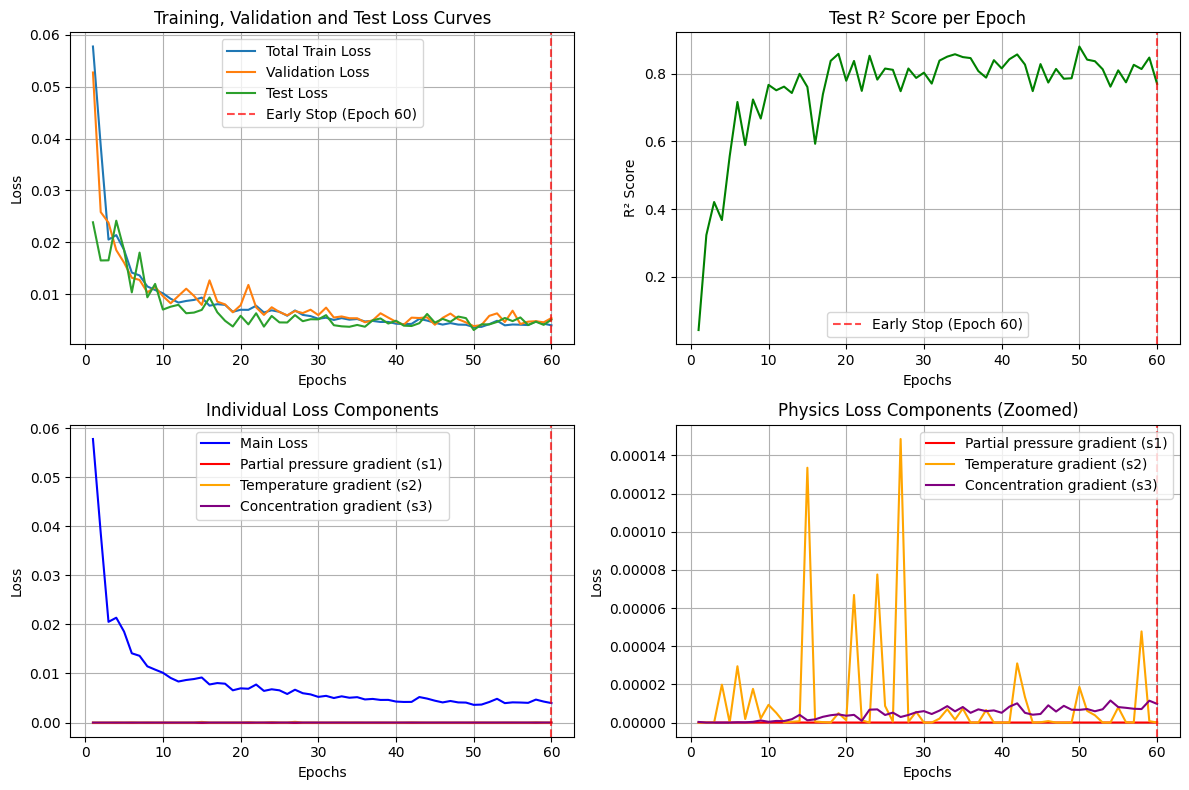

Training Real Time (Wall-Clock Time): 267.72 seconds
Training CPU Time: 244.25 seconds

=== Training Summary ===
Final Total Train Loss: 0.003973
Final Validation Loss: 0.005379
Final Test Loss: 0.005076
Final Test R2: 0.769926
Final Main Loss: 0.003963
Final gradP (s1): 0.000000
Final gradT (s2): 0.000000
Final gradC (s3): 0.000010

Loss data saved to: d:\apri\active\707_Computational_Lab\scope_1/models/models_root/RASHYB_multirun_pinn/losses/losses_32_20250911_003331.csv
Physics loss details saved to: d:\apri\active\707_Computational_Lab\scope_1/models/models_root/RASHYB_multirun_pinn/physics_loss/physics_losses_32_20250911_003331.csv


In [8]:
# TRAIN WITH OPTIMIZED HYPERPARAMETERS
print("Training final model with optimized hyperparameters...")

# Load the data into DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

node_dim = train_data[0].x.size(1)
edge_dim = train_data[0].edge_attr.size(1)

model = ModelArchitecture.VLEAmineCO2(node_dim=node_dim,
                    edge_dim=edge_dim, 
                    hidden_dim=hidden_dim,
                    graph_layers=graph_layers,
                    fc_layers=fc_layers,
                    use_adaptive_pooling=True
                    ).to(device)

criterion = ModelArchitecture.MSLELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Start timing
real_time_start = time.time()  # Real time (wall-clock time)
cpu_time_start = time.process_time()  # CPU time

# Updated to receive all loss components
(train_losses, val_losses, test_losses, test_r2_scores, 
 main_losses, thermo1_losses, thermo2_losses, thermo3_losses,
 stopped_epoch, best_val_loss, best_epoch) = train_model(
    model, train_loader, val_loader, test_loader, 
    criterion, optimizer, 
    pco2_std, temp_std, conc_std, 
    pco2_mean, temp_mean, conc_mean,
    s1, s2, s3, 
    device, num_epochs=num_epochs,
    seed=seed, parent_directory=parent_directory,
    use_physics_in_loss=use_physics_in_loss, 
    monitor_physics=monitor_physics,
    patience=10, min_delta=1e-6)

model_path = f"{parent_directory}/models/models_root/{runtyp}/model_weights/MODEL_{seed}_{runtime}.pth"
os.makedirs(os.path.dirname(model_path), exist_ok=True)
torch.save(model.state_dict(), model_path)
# Enhanced CSV path with individual loss tracking
csv_path = f"{parent_directory}/models/models_root/{runtyp}/losses/losses_{seed}_{runtime}.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

# Write comprehensive loss data to CSV
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    # Write enhanced header with individual loss components
    writer.writerow([
        "Epoch", "Train Loss", "Validation Loss", "Test Loss", "Test R2",
        "Main Loss", "gradP Loss (s1)", "gradT Loss (s2)", "gradC Loss (s3)"
    ])
    
    # Write losses for each epoch including individual components (training)
    for epoch in range(len(train_losses)):
        writer.writerow([
            epoch + 1,
            train_losses[epoch],
            val_losses[epoch],
            test_losses[epoch],
            test_r2_scores[epoch],
            main_losses[epoch],
            thermo1_losses[epoch],
            thermo2_losses[epoch],
            thermo3_losses[epoch]
        ])

# Optional: Save individual physics loss components to separate CSV for detailed analysis
physics_csv_path = f"{parent_directory}/models/models_root/{runtyp}/physics_loss/physics_losses_{seed}_{runtime}.csv"
os.makedirs(os.path.dirname(physics_csv_path), exist_ok=True)
with open(physics_csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Epoch", "Main Loss", "gradP Loss (s1)", "gradT Loss (s2)", "gradC Loss (s3)", "Physics Loss Sum"])
    
    for epoch in range(len(main_losses)):
        physics_sum = thermo1_losses[epoch] + thermo2_losses[epoch] + thermo3_losses[epoch]
        writer.writerow([
            epoch + 1,
            main_losses[epoch],
            thermo1_losses[epoch],
            thermo2_losses[epoch],
            thermo3_losses[epoch],
            physics_sum
        ])

# End timing
real_time_end = time.time()
cpu_time_end = time.process_time()

# Calculate elapsed time
real_time_elapsed = real_time_end - real_time_start
cpu_time_elapsed = cpu_time_end - cpu_time_start

# Output the training time
print(f"Training Real Time (Wall-Clock Time): {real_time_elapsed:.2f} seconds")
print(f"Training CPU Time: {cpu_time_elapsed:.2f} seconds")

# Print summary statistics of loss components
print("\n=== Training Summary ===")
print(f"Final Total Train Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"Final Test R2: {test_r2_scores[-1]:.6f}")
print(f"Final Main Loss: {main_losses[-1]:.6f}")
print(f"Final gradP (s1): {thermo1_losses[-1]:.6f}")
print(f"Final gradT (s2): {thermo2_losses[-1]:.6f}")
print(f"Final gradC (s3): {thermo3_losses[-1]:.6f}")
print(f"\nLoss data saved to: {csv_path}")
print(f"Physics loss details saved to: {physics_csv_path}")

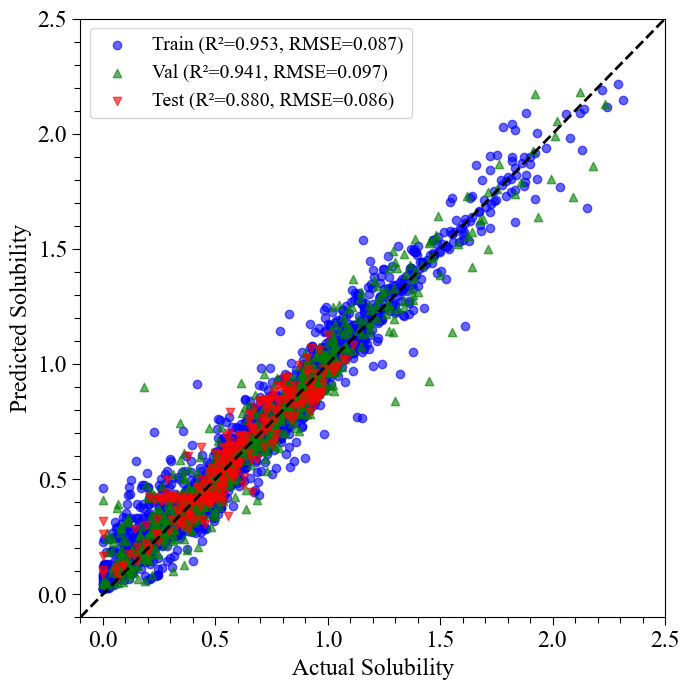

Metrics saved to: d:\apri\active\707_Computational_Lab\scope_1/models/models_root/RASHYB_multirun_pinn/metric_csv\metric_32_20250911_003331.csv


In [9]:
# PARITY PLOT GENERATION
def collect_predictions_and_true_values(model, data_loader, device):
    predictions = []
    true_values = []
    
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            output = model(data)
            predictions.extend(output.cpu().numpy())
            true_values.extend(data.aco2.cpu().numpy())
    
    return predictions, true_values

# Function to calculate R² and RMSE
def calculate_metrics(true_values, predictions):
    r2 = r2_score(true_values, predictions)
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    return r2, rmse

# Function to save metrics to CSV
def save_metrics_to_csv(r2_train, rmse_train, 
                        r2_val, rmse_val, 
                        r2_test, rmse_test, 
                        parent_directory):
    # Create the metrics dictionary
    metrics_data = {
        'Dataset': ['Training', 'Validation', 'Test'],
        'R2': [r2_train, r2_val, r2_test],
        'RMSE': [rmse_train, rmse_val, rmse_test]
    }
    
    # Create DataFrame
    df = pd.DataFrame(metrics_data)
    
    # Create filename with same pattern as model
    filename = f"metric_{seed}_{runtime}.csv"
    filepath = os.path.join(f"{parent_directory}/models/models_root/{runtyp}/metric_csv", filename)
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    # Save to CSV
    df.to_csv(filepath, index=False)
    print(f"Metrics saved to: {filepath}")

# Function to plot the parity plot
def plot_parity_plot(train_true_values, train_predictions, 
                     val_true_values, val_predictions, 
                     test_true_values, test_predictions
                     ):
    fontsize = 17
    matplotlib.rcParams['font.family'] = 'Times New Roman'

    # Calculate metrics
    r2_train, rmse_train = calculate_metrics(train_true_values, train_predictions)
    r2_val, rmse_val    = calculate_metrics(val_true_values, val_predictions)
    r2_test, rmse_test = calculate_metrics(test_true_values, test_predictions)

    # Unified parity plot
    plt.figure(figsize=(7, 7))

    # Scatter plots
    plt.scatter(train_true_values, train_predictions, 
                edgecolors='b', alpha=0.6, c='b', marker='o', label=f'Train (R²={r2_train:.3f}, RMSE={rmse_train:.3f})')
    plt.scatter(val_true_values, val_predictions, 
                edgecolors='g', alpha=0.6, c='g', marker='^', label=f'Val (R²={r2_val:.3f}, RMSE={rmse_val:.3f})')
    plt.scatter(test_true_values, test_predictions, 
                edgecolors='r', alpha=0.6, c='r', marker='v', label=f'Test (R²={r2_test:.3f}, RMSE={rmse_test:.3f})')

    # Parity line
    max_val = max(max(train_true_values), max(val_true_values), max(test_true_values))
    plt.plot([-0.1, max_val+0.5], [-0.1, max_val+0.5], 'k--', linewidth=2)

    # Labels & ticks
    plt.xlabel('Actual Solubility', fontsize=fontsize)
    plt.ylabel('Predicted Solubility', fontsize=fontsize)
    plt.xlim(-0.1, 2.5)
    plt.ylim(-0.1, 2.5)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.minorticks_on()

    # Customize tick appearance
    plt.tick_params(axis='both', which='major', length=6, width=0.8)   # longer, thicker major ticks
    plt.tick_params(axis='both', which='minor', length=4, width=0.8)   # shorter, thinner minor ticks

    # Legend
    plt.legend(fontsize=fontsize-3, loc='upper left', frameon=True)

    plt.tight_layout()
    plt.show()

    # Save metrics if needed
    save_metrics_to_csv(r2_train, rmse_train, r2_val, rmse_val, r2_test, rmse_test, parent_directory)

# Collect predictions and true values for training, validation, and test data
train_predictions, train_true_values = collect_predictions_and_true_values(model, train_loader, device)
val_predictions, val_true_values = collect_predictions_and_true_values(model, val_loader, device)
test_predictions, test_true_values = collect_predictions_and_true_values(model, test_loader, device)

# Plot the parity plot
plot_parity_plot(train_true_values, train_predictions, 
                 val_true_values, val_predictions, 
                 test_true_values, test_predictions
                 )